## Задача

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

## 1. Загрузим данные и проверим входные условия

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from tqdm.auto import tqdm
from scipy.stats import norm

plt.style.use('ggplot')

%matplotlib inline

In [3]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';', index_col=['user_id'])
df.head()

,revenue,testgroup
user_id,,
1,0,b
2,0,a
3,0,a
4,0,b
5,0,b


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404770 entries, 1 to 404770
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   revenue    404770 non-null  int64 
 1   testgroup  404770 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.3+ MB


In [5]:
a_group = df.query("testgroup == 'a'")
b_group = df.query("testgroup == 'b'")

In [6]:
a_group.shape

(202103, 2)

In [7]:
b_group.shape

(202667, 2)

In [8]:
a_group.shape[0] + b_group.shape[0]

404770

Размеры выборок совпадают с условием

In [9]:
a_group.query('revenue != 0').revenue.count()

1928

In [10]:
b_group.query('revenue != 0').revenue.count()

1805

Количество покупок совпадает с условием

In [11]:
a_group.describe(percentiles=[0, 0.25, 0.5, 0.75, 0.99]) #очень мало покупок. почти все значения - нули

,revenue
count,202103.000000
mean,25.413720
std,920.768137
min,0.000000
0%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
99%,0.000000
max,37433.000000


## 2. Проверим основные метрики

In [12]:
revenue_a = a_group.revenue.sum()
print(f"Выручка контрольной группы равняется {revenue_a}")

Выручка контрольной группы равняется 5136189


In [13]:
revenue_b = b_group.revenue.sum()
print(f"Выручка тестовой группы равняется {revenue_b}")

Выручка тестовой группы равняется 5421603


In [14]:
avg_check_a = np.round((a_group.revenue.sum() / a_group.query('revenue > 0').revenue.count()),2)
print(f"Средний чек контрольной группы равняется {avg_check_a}")

Средний чек контрольной группы равняется 2664.0


In [15]:
avg_check_b = np.round(b_group.revenue.sum() / b_group.query('revenue > 0').revenue.count(),2)
print(f"Средний чек тестовой группы равняется {avg_check_b}")

Средний чек тестовой группы равняется 3003.66


In [16]:
arpu_a = np.round(a_group.revenue.sum() / a_group.revenue.count(), 2)
print(f"Средний доход на пользователя в контрольной группе равняется {arpu_a}")

Средний доход на пользователя в контрольной группе равняется 25.41


In [17]:
arpu_b = np.round(b_group.revenue.sum() / b_group.revenue.count(), 2)
print(f"Средний доход на пользователя в тестовой группе равняется {arpu_b}")

Средний доход на пользователя в тестовой группе равняется 26.75


In [18]:
arppu_a = np.round(a_group.revenue.sum() / a_group.query('revenue > 0').reset_index().user_id.nunique(), 2)
print(f"Средний доход на платящего пользователя в контрольной группе равняется {arppu_a}")

Средний доход на платящего пользователя в контрольной группе равняется 2664.0


In [19]:
arppu_b = np.round(b_group.revenue.sum() / b_group.query('revenue > 0').reset_index().user_id.nunique(), 2)
print(f"Средний доход на платящего пользователя в тестовой группе равняется {arppu_b}")

Средний доход на платящего пользователя в тестовой группе равняется 3003.66


In [20]:
arpu_change = np.round((arpu_b - arpu_a) / arpu_a * 100, 2)
print(f"Средний доход на пользователя вырос на " + "\x1b[1;31m" + f"{arpu_change}%" + "\x1b[0m")

Средний доход на пользователя вырос на 5.27%


In [21]:
arppu_change = np.round((arppu_b - arppu_a) / arppu_a * 100, 2)
print("Средний доход на платящего пользователя вырос на " + "\x1b[1;31m" + f"{arppu_change}%" + "\x1b[0m")

Средний доход на платящего пользователя вырос на 12.75%


## 3. Проверим группы на наличие статистически значимых различий

In [22]:
from scipy.stats import iqr
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

Мы знаем, что у нас есть только две группы с одной зависимой переменной - выручкой. Проверим выборки на нормальность распределения, чтобы определиться со статистическим методом

Чтобы проверить выборки на нормальность, воспользуемся критерием Шапиро-Уилка. За нулевую гипотезу принимается утверждение, что выборки распределены нормально. Для использования метода лучше использовать небольшие обемы данных, поэтому передадим в функцию подвыборку из каждой группы.

In [23]:
shapiro(a_group.revenue.sample(1000))

(0.013938724994659424, 0.0)

In [24]:
shapiro(b_group.revenue.sample(1000))

(0.07786321640014648, 0.0)

Как видим, p-value в обоих случаях показал нулевой результат. Это значит, что мы можем отклонить нулевую гипотезу о нормальном распределении этих выборок.
Чтобы убедиться, посмотрим на графики

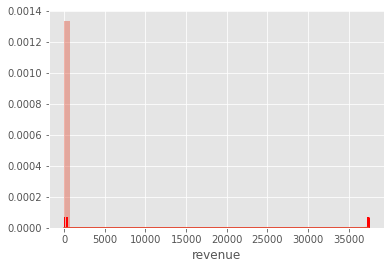

In [25]:
sns.distplot(a=a_group.revenue, rug = True, rug_kws = {'color' : 'r'}, kde_kws = {'bw' : 1})

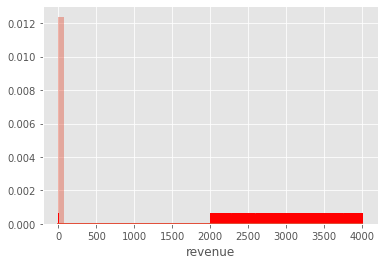

In [26]:
sns.distplot(a=b_group.revenue, rug = True, rug_kws = {'color' : 'r'}, kde_kws = {'bw' : 1})

В обоих случаях видно, что распределния далеки от нормальных, их можно отнести к разновидности Zero-inflated model, то есть моделей, в которой большая часть значений сконцентрирована около нуля.


Получается, что выборки распределены ненормально, поэтому мы можем использовать только непараметрические статистические методы.
Проверим сходство выборок с помощью бутстрапа и u-test'а.

### Bootstrap

Основная функция для проведения бутстрап-тестирования. Позволяет регулировать количество итераций, исследуемую статистику, уровень значимости. На выходе получаем p-value, доверительный интервал и значения статистики на каждой итерации.

In [27]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}


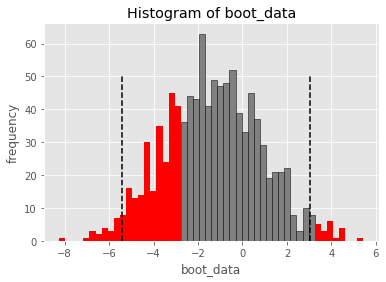

In [28]:
bootstrap_model = get_bootstrap(a_group.revenue, b_group.revenue, boot_it = 1000, statistic = np.mean, bootstrap_conf_level = 0.95)

In [29]:
print(f"Значение p-value при проверки статистически значимых различий равяется {bootstrap_model['p_value']}")

Значение p-value при проверки статистически значимых различий равяется 0.5380007625002179


Результат бутстрапа говорит нам о том, что статистически значимых различий между контрольной и тестовой группами нет. То есть результат, который мы получили в результате А/В-теста, является случайным.

### U-критерий Манна-Уитни

Следующий непараметрический метод для проверки наличия различий между выборками используем U-критерий Манна-Уитни.

In [30]:
u_test = mannwhitneyu(a_group.revenue, b_group.revenue)
print(f"Значение p-value при проверки статистически значимых различий равяется {u_test[1]}")

Значение p-value при проверки статистически значимых различий равяется 0.03134850658037196


Получаем противоположный результат. Значение p-value в данном случае дает нам возможность отклонить нулевую гипотезу об отличии различий между выборками

## Промежуточный итог

- Посмотрели основные метрики увидели явный прирост в тестовой группе
- При проверке гипотезы об отсутствии различий между выборками, бутстрап сказал, что разницы между выборками нет
- При проверке гипотезы об отсутствии различий между выборками, U-тест сказал, что разница между выборками есть
- Кому верить - непонятно

## Продолжаем погружение в данные

Мы знаем, что большинство пользователей нашего приложения никогда покупок не совершали. Что если их исключить, и посмотреть, как изменилось распределение платящих пользователей?

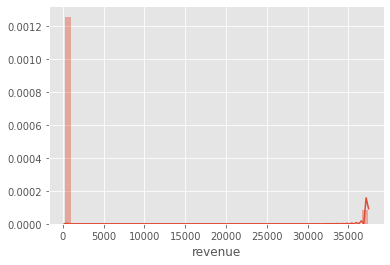

In [31]:
sns.distplot(a=a_group.query('revenue > 0').revenue)

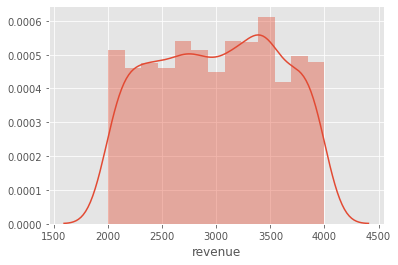

In [32]:
sns.distplot(a=b_group.query('revenue > 0').revenue)

В тестовой группе видно, что основные покупки происходили в от 2000 до 4000.
В контрольной группе картина не поменялась. Продолжим увеличивать порог.

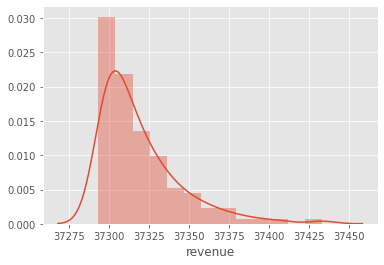

In [33]:
sns.distplot(a=a_group.query('revenue > 35000').revenue)

Хорошо, видим покупки на порядок дороже, чем в тестовой группе.
Остается вопрос, почему мы не получили такой график с первого раза? Попробуем поменять знак условия и исключить нулевые покупки.

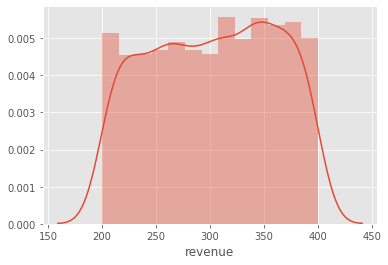

In [34]:
sns.distplot(a=a_group.query('revenue < 35000 & revenue > 0').revenue)

Получается, что в тестовой группе было два типа покупок с довольно малой и довольно высокой стоимостью.
Оценим покупки во всех группах количиственно

In [64]:
a_group.query('revenue < 35000 & revenue > 0').describe()

,revenue
count,1805.000000
mean,302.458172
std,57.914246
min,200.000000
25%,254.000000
50%,305.000000
75%,352.000000
max,400.000000


In [65]:
a_group.query('revenue > 35000').describe()

,revenue
count,123.000000
mean,37319.121951
std,25.442183
min,37293.000000
25%,37301.000000
50%,37311.000000
75%,37329.000000
max,37433.000000


In [66]:
b_group.query('revenue > 0').describe()

,revenue
count,1805.000000
mean,3003.658172
std,572.619709
min,2000.000000
25%,2513.000000
50%,3022.000000
75%,3478.000000
max,4000.000000


 - если учитывать только платящих пользователей, то контрольная группа имеет бимодальное распределение со средними в 302 и 37319
 - в тестовой группе только одна группа платящих пользователей со средним в 3003

## Вывод

 - не смотря на то, что платящих пользователей в тестовой группе меньше, ARPPU(средняя выручка на платящего пользователя) и выручка выше, чем в контрольной группе: 2664 и 5421603 в тестовой, против  3004 и 5136189 в контрольной.
 - непараметрически тесты дали протеворечивые результаты, то есть мы одназначно не можем сказать имеются ли различия между тестовыми группами или нет. 
 - Однако деньги нам говорят о том, что в тестовой группе мы начали зарабатывать на 5.5% больше. 
 - К тому же можно точно сказать, что изменился характер покупок, то есть пользователи стали покупать другой тип товара и в таких объемах, что подняли выручку: то есть они стали покупать много товаров из средней ценовой категории и доход от этих товаров перекрыл доход от суммы покупок такого же количества недорогих и небольшого количества дорогих товаров. 
 - Стоит дальше проводить эксперименты с покупками из средней ценовой категории